In [96]:
import datasets
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import openai
from sklearn.model_selection import train_test_split
import json
import time 

In [50]:
openai.api_key = "Enter API KEY"

In [51]:
dataset = datasets.load_dataset('financial_phrasebank', 'sentences_allagree')

In [52]:
df = pd.DataFrame(dataset['train'])

In [53]:
df.head(10)

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
5,Finnish Talentum reports its operating profit ...,2
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2
7,Consolidated net sales increased 16 % to reach...,2
8,Foundries division reports its sales increased...,2
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",2


In [54]:
df['label'].skew()

-0.06717208823404655

In [55]:
id_to_label = {0 : 'negative', 1 : 'neutral' ,  2 : 'postive'}

In [56]:
df["label"] = df["label"].map(id_to_label)

In [57]:
categories = df['label'].unique()

In [58]:
train_df, test_df = train_test_split(df, test_size=100/283, stratify=df['label'], random_state=42)

In [70]:
categories = train_df['label'].unique()

In [71]:
def text_to_openai_json(data,filename):
    """
    Converts a given dataset into a JSON Lines (JSONL) file suitable for OpenAI's GPT-3.5 turbo model.
    
    Args:
        data (DataFrame or similar data structure): Input data containing text and labels.

    The function processes the input data row by row, constructing conversations for each row with a system message, user message, and an assistant message. It then writes the generated conversation data to a JSONL file.
 
    """
    # Initialize an empty list to store conversation data
    message_list = []

    # Iterate through the rows in the input data
    for _, row in data.iterrows():
        # Create a system message as an initial instruction
        system_message = {
            "role": "system",
            "content": f"given the following text: find the category in: {categories} that is most closely associated with it. Return only the category name"
        }

        # Append the system message to the conversation
        message_list.append({"messages": [system_message]})

        # Create a user message based on the 'text' column from the data
        user_message = {
            "role": "user",
            "content": row['sentence']
        }

        # Append the user message to the conversation
        message_list[-1]["messages"].append(user_message)

        # Create an assistant message based on the 'coarse_label' column from the data
        assistant_message = {
            "role": 'assistant',
            "content": row['label']
        }

        # Append the assistant message to the conversation
        message_list[-1]["messages"].append(assistant_message)

    # Write the conversation data to a JSON Lines (JSONL) file
    with open(filename, "w") as json_file:
        for message in message_list:
            # Serialize the conversation data to JSON and write it to the file
            json.dump(message, json_file)
            json_file.write("\n")

In [72]:
system_content =  f"given the following text: find the category in: {categories} that is most closely associated with it. Return only the category name only in following format"

In [73]:
from sklearn.metrics import precision_recall_fscore_support

In [87]:
def zero_shot_model(data,model_id):
    pred = []
    for row in data["sentence"]:
        completion = openai.ChatCompletion.create(
            model= model_id ,
            messages=[
                {"role": "system", "content": system_content },
                {"role": "user", "content": row }
            ])
        
        print(f'text: {row}')
        print(completion.choices[0].message.content)
        pred.append(completion.choices[0].message.content)
    pred_df = pd.DataFrame({'sentence': data["sentence"], 'label' : data['label'], 'few-shot predictions' : pred })
    
    return pred_df

In [88]:
cumulative_increment = 0
model_id = 'gpt-3.5-turbo-0301'
all_model_id = []

In [91]:
def fine_tune_model(model_id,num_label,pred_df):
    incorrection_pred_df = pred_df[pred_df['label'] != pred_df['few-shot predictions']][:num_label]
    filename = f'ft_increment_{num_label}.jsonl'
    text_to_openai_json(incorrection_pred_df, filename)
    loader = openai.File.create(file=open(filename, "rb"), purpose='fine-tune')
    fine_tuning_job = openai.FineTuningJob.create(training_file=loader.id, model="gpt-3.5-turbo")
    return fine_tuning_job.id

In [ ]:
def wait_for_fine_tuning(job_id):
    while True:
        response = openai.FineTuningJob.retrieve(job_id)
        print(response["fine_tuned_model"])
        if response["fine_tuned_model"]:
            print(response["fine_tuned_model"])
            return response["fine_tuned_model"]
        time.sleep(60)  # Check every 60 seconds

In [92]:
def ft_accuracy(data,model_id):
    pred = []
    for row in data["sentence"]:
        completion = openai.ChatCompletion.create(
            model= model_id ,
            messages=[
                {"role": "system", "content": system_content },
                {"role": "user", "content": row }
            ])
        
        print(f'text: {row}')
        print(completion.choices[0].message.content)
        pred.append(completion.choices[0].message.content)
        
    accuracy = accuracy_score(data['label'], pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    precision, recall, f1, _ = precision_recall_fscore_support(data['label'], pred, average='macro',zero_division=1)
    
    return accuracy, precision, recall, f1, pred

In [93]:
test_df.head()

,sentence,label
971,"Following the issue , the new shares will cons...",neutral
540,"An of the invention , released by the Patent ...",neutral
1621,Currently it operates a fleet of eight carrier...,neutral
2143,In a separate announcement to the Helsinki sto...,negative
25,"In January , traffic , measured in revenue pas...",postive


In [1]:
pred_df = zero_shot_model(model_id='gpt-3.5-turbo-0301', data = test_df)

In [2]:
model_ids = []
accs = [] 
precisions = [] 
recalls = [] 
f1s = []
labels = []
label_count = 0
for i in range(15):
    label_count += 10
    ft_id = fine_tune_model(model_id = 'gpt-3.5-turbo-0301', num_label=label_count, pred_df=pred_df)
    if wait_for_fine_tuning(ft_id) is not None:
        model_ids.append(wait_for_fine_tuning(ft_id))
        accuracy, precision, recall, f1, pred = ft_accuracy(data=test_df,model_id=(wait_for_fine_tuning(ft_id)))
        labels.append(label_count)
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

"model_ids = []\naccs = [] \nprecisions = [] \nrecalls = [] \nf1s = []\nlabels = []\nlabel_count = 0\nfor i in range(15):\n    label_count += 10\n    ft_id = fine_tune_model(model_id = 'gpt-3.5-turbo-0301', num_label=label_count, pred_df=pred_df)\n    if wait_for_fine_tuning(ft_id) is not None:\n        model_ids.append(wait_for_fine_tuning(ft_id))\n        accuracy, precision, recall, f1, pred = ft_accuracy(data=test_df,model_id=(wait_for_fine_tuning(ft_id)))\n        labels.append(label_count)\n        accs.append(accuracy)\n        precisions.append(precision)\n        recalls.append(recall)\n        f1s.append(f1)"

# Confusion Matrix


In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt

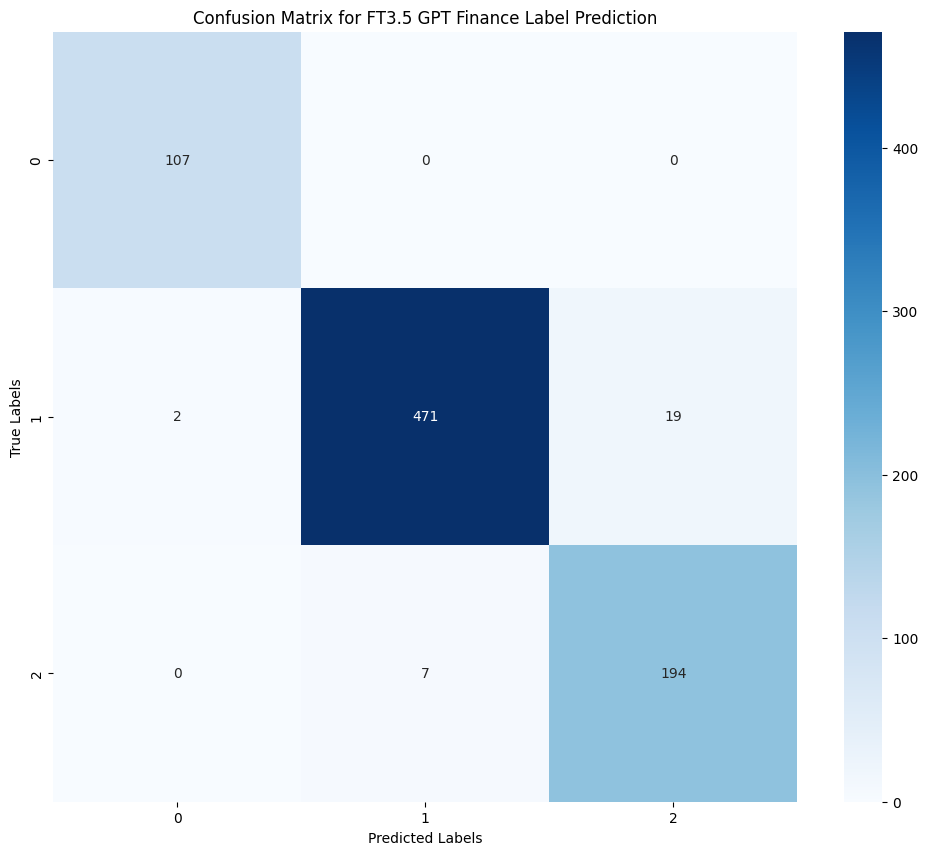

In [119]:
cm = confusion_matrix( test_df['label'],pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FT3.5 GPT Finance Label Prediction')
plt.show()